<a href="https://colab.research.google.com/github/greek-nlp/benchmark/blob/main/gr_author_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Dataset

In [1]:
%%capture
!git clone https://github.com/greek-nlp/gen-a.git
!git clone https://github.com/greek-nlp/benchmark.git
!pip install zenodo-get
!pip install datasets
!pip install conll-df

import pandas as pd
import importlib

gr_data = pd.read_csv('gen-a/data.csv')
gena = importlib.import_module("gen-a.data_wrapper")

In [ ]:
barzokas = gena.BarzokasDt(datasets=gr_data).get('train')
barzokas.drop_duplicates(inplace=True, subset=['text'])
barzokas = barzokas[barzokas.status=='parsable']
barzokas = barzokas[barzokas.tokensCount>1000]

Download github items in directory: /content/repo_56
Successfully downloaded data/corpora


['Θανάσης Τριαρίδης', 'Γιάννης Αντάμης', 'Κώστας Βουλαζέρης', 'Πάνος Κολιόπουλος', 'Δημήτρης Τζουβάλης', 'Plato', 'Ράνια Συνοδινού', 'Γιώργος Σ. Κόκκινος', 'Πάνος Α. Ζέρβας', 'Ευρυδίκη Αμανατίδου', 'Κατερίνα Καζολέα', 'Τέος Ρόμβος', 'Χάρης Γαντζούδης', 'Φρίντα Κριτσωτάκη', 'Πασχάλης Παπαβασιλείου', 'Βασίλειος Κάππας', 'Αύγουστος Κορτώ']


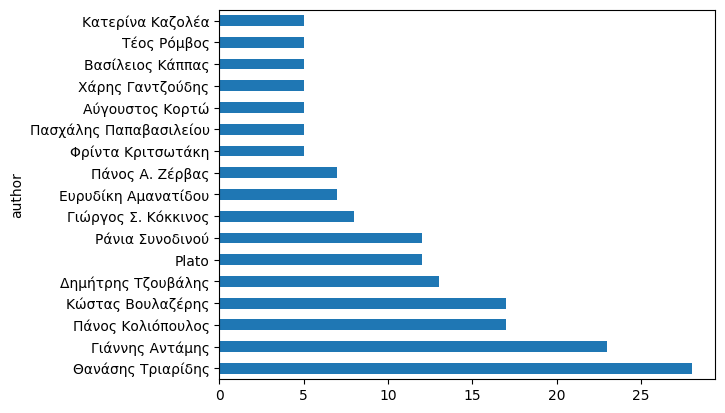

In [ ]:
authors = barzokas.author.value_counts()[:17].index.tolist()
barzokas_pop = barzokas[barzokas.author.isin(authors)]
print(authors)
barzokas_pop.author.value_counts().plot(kind='barh');

In [ ]:
import random

def get_random_middle_excerpt(text, length=1000, offset_range=10000):
  """
  Returns an excerpt by choosing a random start point within
  a certain range around the absolute middle of the text.
  """
  text_length = len(text)

  # 1. Find the ideal middle start (if we were taking the fixed middle)
  middle_start_ideal = text_length // 2 - length // 2

  # 2. Define the range for the random starting point
  # The starting point will be between:
  #   max(0, middle_start_ideal - offset_range)
  # and
  #   min(text_length - length, middle_start_ideal + offset_range)

  # Ensure the start index is not negative and the excerpt fits in the text
  min_start = max(0, middle_start_ideal - offset_range // 2)
  max_start = min(text_length - length, middle_start_ideal + offset_range // 2)

  # Handle cases where the text is too short
  if min_start >= max_start:
      return text[:length] # Just return the first part or the whole text if shorter

  # 3. Pick a random starting index
  start_index = random.randint(min_start, max_start)

  # 4. Extract the excerpt
  return text[start_index : start_index + length]

# To get multiple diverse, yet middle-focused samples:
# sample1 = get_random_middle_excerpt(text)
# sample2 = get_random_middle_excerpt(text)

In [ ]:
%%capture
# Loop 10 times to create 10 new columns
for i in range(1, 11):
  barzokas_pop[f'excerpt_{i}'] = barzokas_pop.text.apply(get_random_middle_excerpt)

In [ ]:
barzokas_pop.to_csv('barzokas_10excerpts.csv.gz', compression='gzip')

# Exploratory

In [ ]:
barzokas_pop.sample()

,id,title,author,type,publishedYear,isbn,filename,postUrl,attachmentUrl,authorYearOfBirth,...,excerpt_1,excerpt_2,excerpt_3,excerpt_4,excerpt_5,excerpt_6,excerpt_7,excerpt_8,excerpt_9,excerpt_10
975,openBook1393,"Τιμόκλη, φέτος να σμίγουμε ξανά",Πάνος Α. Ζέρβας,Διήγημα,2016,NaN,"Τιμόκλη, φέτος να σμίγουμε ξανά.pdf",https://www.openbook.gr/timokli-fetos-na-smigo...,http://bit.ly/2Tkl4ks,NaN,...,ο μοναχόςπρέπει να αποφεύγει κάθε δημόσια...,κά η Ηγουμένηπρέπει να αναγνωρίζει ότι θα δώσε...,"χή, την μετάνοια και να δοξάζετε τον Θεό»«Αδια...","ίστη και ζήλο,γεμάτη πνευματικά χαρίσματα…»«...",ναστροφή με την πόρνηγυναίκα: Απέλιπες την...,είναι φοβερόνα διασωθεί κανείς από το πέλαγος ...,ένηται αυτή έμμισθος η υπακοή. Κάθε δε α...,αιπρέπει να φροντίζει να μη εισαγάγει τον κόσμ...,"λύπης ή εξ ανάγκης,ίνα γένηται αυτή έμμισθο...",την αξία Ηγουμένη σας Χρυσοστόμη έναν πν...


In [ ]:
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Use TF-IDF for vectorization
vectorizer = TfidfVectorizer()

excerpt_columns = [f'excerpt_{i}' for i in range(1, 11)]
overlap_data_cosine = []

for index, row in barzokas_pop.iterrows():
    row_data = row[excerpt_columns].tolist()

    # Handle cases with empty strings or very short texts that might cause errors in TF-IDF
    # Filter out None or empty strings before vectorization
    row_data_filtered = [text for text in row_data if isinstance(text, str) and text.strip()]

    if len(row_data_filtered) < 2:
        # Not enough valid excerpts to calculate pairwise similarity
        row_overlap = {f'{col1}_{col2}_overlap_cosine': 0.0 for col1, col2 in itertools.combinations(excerpt_columns, 2)}
    else:
        try:
            # Fit and transform the excerpts
            tfidf_matrix = vectorizer.fit_transform(row_data_filtered)

            # Calculate cosine similarity
            cosine_sim_matrix = cosine_similarity(tfidf_matrix)

            # Map the results back to original excerpt columns
            # Create a mapping from filtered indices back to original excerpt column names
            filtered_to_original_col = {i: col for i, col in enumerate(excerpt_columns) if row_data[excerpt_columns.index(col)] in row_data_filtered}

            row_overlap = {}
            for i, j in itertools.combinations(range(len(row_data_filtered)), 2):
                original_col1 = filtered_to_original_col[i]
                original_col2 = filtered_to_original_col[j]
                row_overlap[f'{original_col1}_{original_col2}_overlap_cosine'] = cosine_sim_matrix[i, j]

            # Fill in 0.0 for pairs that included filtered out excerpts
            all_pairs = itertools.combinations(excerpt_columns, 2)
            for col1, col2 in all_pairs:
                if f'{col1}_{col2}_overlap_cosine' not in row_overlap:
                     row_overlap[f'{col1}_{col2}_overlap_cosine'] = 0.0


        except ValueError as e:
            print(f"Could not process row {index}: {e}")
            row_overlap = {f'{col1}_{col2}_overlap_cosine': 0.0 for col1, col2 in itertools.combinations(excerpt_columns, 2)}


    overlap_data_cosine.append(row_overlap)


overlap_df_cosine = pd.DataFrame(overlap_data_cosine, index=barzokas_pop.index)

# Display the first few rows of the overlap DataFrame
display(overlap_df_cosine.head())

,excerpt_1_excerpt_2_overlap_cosine,excerpt_1_excerpt_3_overlap_cosine,excerpt_1_excerpt_4_overlap_cosine,excerpt_1_excerpt_5_overlap_cosine,excerpt_1_excerpt_6_overlap_cosine,excerpt_1_excerpt_7_overlap_cosine,excerpt_1_excerpt_8_overlap_cosine,excerpt_1_excerpt_9_overlap_cosine,excerpt_1_excerpt_10_overlap_cosine,excerpt_2_excerpt_3_overlap_cosine,...,excerpt_6_excerpt_7_overlap_cosine,excerpt_6_excerpt_8_overlap_cosine,excerpt_6_excerpt_9_overlap_cosine,excerpt_6_excerpt_10_overlap_cosine,excerpt_7_excerpt_8_overlap_cosine,excerpt_7_excerpt_9_overlap_cosine,excerpt_7_excerpt_10_overlap_cosine,excerpt_8_excerpt_9_overlap_cosine,excerpt_8_excerpt_10_overlap_cosine,excerpt_9_excerpt_10_overlap_cosine
537,0.311619,0.212097,0.232661,0.147748,0.277490,0.179719,0.240015,0.235151,0.218422,0.248619,...,0.174976,0.263877,0.272715,0.234968,0.236477,0.207736,0.223907,0.283674,0.238305,0.279771
541,0.254827,0.248696,0.627691,0.273974,0.259370,0.266920,0.222999,0.406324,0.668865,0.251994,...,0.921301,0.212932,0.215091,0.190877,0.233166,0.227632,0.176779,0.216434,0.217108,0.326702
545,0.275108,0.343141,0.228577,0.333074,0.269800,0.215511,0.304553,0.351401,0.353529,0.314703,...,0.264885,0.248295,0.271959,0.306867,0.233529,0.272991,0.272811,0.330996,0.310982,0.368344
552,0.202411,0.202704,0.165385,0.131428,0.674082,0.467137,0.158614,0.203798,0.259366,0.307257,...,0.222053,0.178907,0.157478,0.215744,0.160874,0.243878,0.311676,0.233611,0.190481,0.242669
561,0.193854,0.181370,0.928689,0.237305,0.502246,0.241045,0.215358,0.229826,0.272320,0.246749,...,0.220578,0.248066,0.247556,0.560299,0.215370,0.279025,0.718325,0.202920,0.242075,0.306536


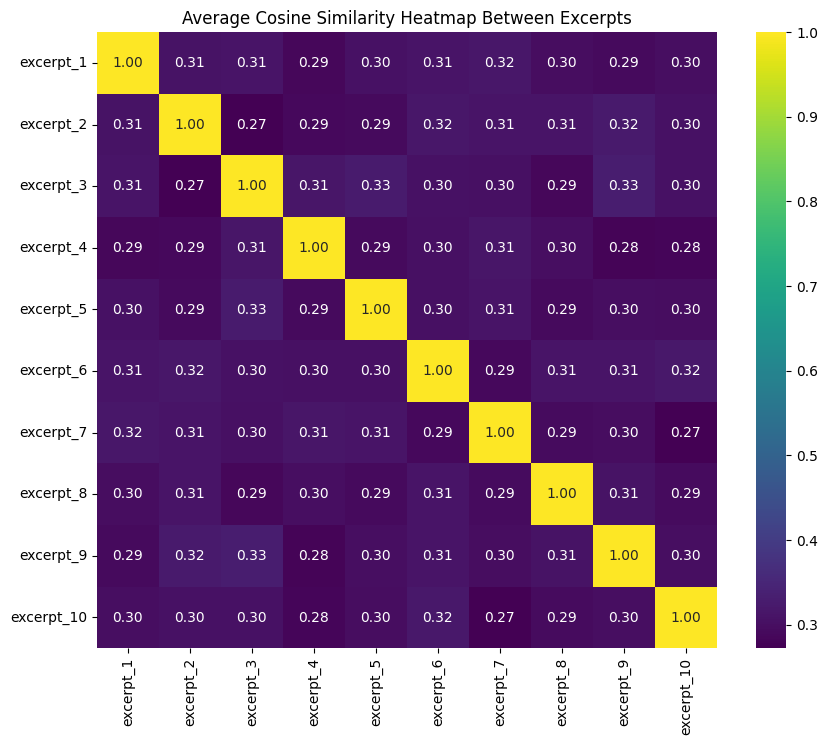

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the average overlap for each pair of excerpts from the cosine similarity DataFrame
average_overlap_series_cosine = overlap_df_cosine.mean()

# Reshape the series into a square DataFrame for the heatmap
overlap_matrix_cosine = pd.DataFrame(0.0, index=range(1, 11), columns=range(1, 11))

for col_name, avg_overlap in average_overlap_series_cosine.items():
    # Extract excerpt numbers from the column name (e.g., 'excerpt_1_excerpt_2_overlap_cosine')
    parts = col_name.split('_')
    i = int(parts[1])
    j = int(parts[3])
    overlap_matrix_cosine.loc[i, j] = avg_overlap
    overlap_matrix_cosine.loc[j, i] = avg_overlap # Heatmap is symmetric

# Fill the diagonal with 1.0 as an excerpt has perfect overlap with itself
for i in range(1, 11):
    overlap_matrix_cosine.loc[i, i] = 1.0


# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(overlap_matrix_cosine, annot=True, cmap='viridis', fmt=".2f", xticklabels=[f'excerpt_{i}' for i in range(1, 11)], yticklabels=[f'excerpt_{i}' for i in range(1, 11)])
plt.title('Average Cosine Similarity Heatmap Between Excerpts')
plt.show()

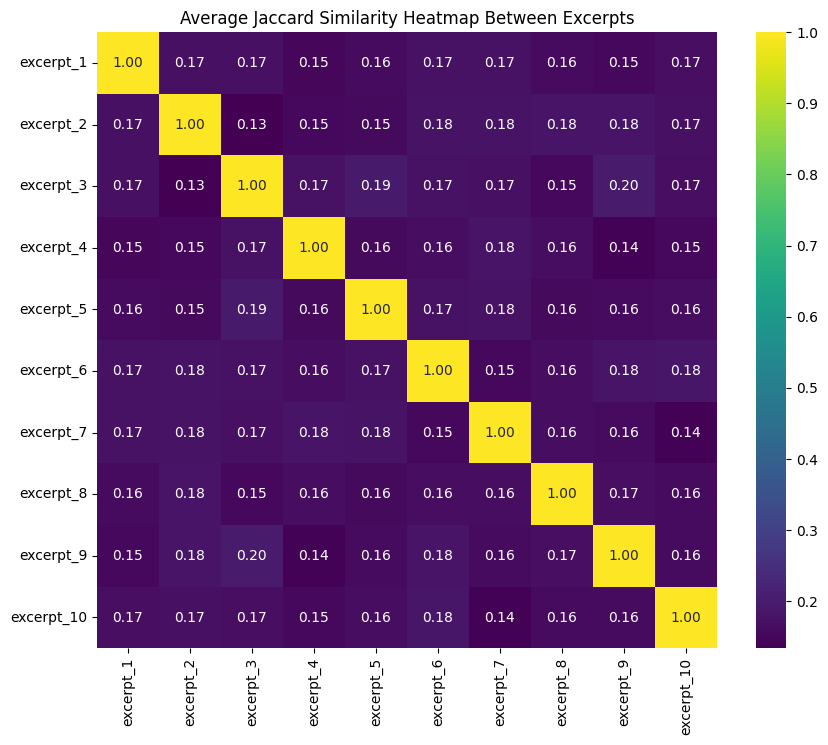

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the average overlap for each pair of excerpts
# The columns in overlap_df are already in the format 'excerpt_i_excerpt_j_overlap'
# We can directly calculate the mean of each column
average_overlap_series = overlap_df.mean()

# Reshape the series into a square DataFrame for the heatmap
# We need to extract the excerpt numbers from the column names
overlap_matrix = pd.DataFrame(0.0, index=range(1, 11), columns=range(1, 11))

for col_name, avg_overlap in average_overlap_series.items():
    # Extract excerpt numbers from the column name (e.g., 'excerpt_1_excerpt_2_overlap')
    parts = col_name.split('_')
    i = int(parts[1])
    j = int(parts[3])
    overlap_matrix.loc[i, j] = avg_overlap
    overlap_matrix.loc[j, i] = avg_overlap # Heatmap is symmetric

# Fill the diagonal with 1.0 as an excerpt has perfect overlap with itself
for i in range(1, 11):
    overlap_matrix.loc[i, i] = 1.0


# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(overlap_matrix, annot=True, cmap='viridis', fmt=".2f", xticklabels=[f'excerpt_{i}' for i in range(1, 11)], yticklabels=[f'excerpt_{i}' for i in range(1, 11)])
plt.title('Average Jaccard Similarity Heatmap Between Excerpts')
plt.show()

# Load and explore

In [2]:
!gdown 17Ks0Q8GFsunj5w3PoHwcG1vTm_bfLhpL

Downloading...
From: https://drive.google.com/uc?id=17Ks0Q8GFsunj5w3PoHwcG1vTm_bfLhpL
To: /content/barzokas_10excerpts.csv.gz
100% 19.7M/19.7M [00:00<00:00, 69.4MB/s]


In [3]:
import pandas as pd
barzokas_pop = pd.read_csv('barzokas_10excerpts.csv.gz', index_col=0)
pop_authors = barzokas_pop.author.value_counts().index.tolist()
pop_authors

['Θανάσης Τριαρίδης',
 'Γιάννης Αντάμης',
 'Πάνος Κολιόπουλος',
 'Κώστας Βουλαζέρης',
 'Δημήτρης Τζουβάλης',
 'Plato',
 'Ράνια Συνοδινού',
 'Γιώργος Σ. Κόκκινος',
 'Ευρυδίκη Αμανατίδου',
 'Πάνος Α. Ζέρβας',
 'Φρίντα Κριτσωτάκη',
 'Πασχάλης Παπαβασιλείου',
 'Αύγουστος Κορτώ',
 'Χάρης Γαντζούδης',
 'Βασίλειος Κάππας',
 'Τέος Ρόμβος',
 'Κατερίνα Καζολέα']

In [11]:
regex_pattern = '|'.join(pop_authors)
for i in range(1, 11):
  barzokas_pop[f'excerpt_{i}'] = barzokas_pop[f'excerpt_{i}'].str.replace(regex_pattern, '', regex=True, case=True)

In [14]:
# sanity check
barzokas_pop['excerpt_1'].str.contains(regex_pattern, case=True, na=False).sum()

np.int64(0)

In [16]:
barzokas_pop.to_csv('barzokas_10ex_anonymized.csv.gz', compression='gzip')